# Wczytanie danych

In [5]:
pip install covid19dh

Jako kraj do lokalnej analizy wybrałem Włochy

In [6]:
from covid19dh import covid19
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

global_x1, global_src = covid19(verbose = False) 
local_x1,local_src = covid19("Italy",verbose = False)

In [7]:
global_x = global_x1.copy()
local_x = local_x1.copy()

# EDA

Dane podzielone są na kilka segmentów:
1. ❌Identifiers - data oraz unikalne id
2. ✅**Epidemiological variables** - numeryczne dane na temat pandemii ( np. liczba przypadkow, zgony)
Tych daych będziemy używać w naszym projekcie
3. ❌Policy measures - dane na temat polityki wprowadzonych obostrzeń, testów oraz szczepień
4. ❌Administrative areas
5. ❌Coordinates
6. ❌ISO codes
7. ❌External Keys 



## Wybranie danych do analizy

Wybieramy dane jedynie z segmentu **Epidemiological variables**. Zostawimy również datę, ponieważ przyda się nam ona w późniejszym etapie.

In [8]:
global_x = global_x.iloc[:,1:12]
local_x = local_x.iloc[:,1:12]

In [9]:
print( pd.isnull(local_x["vent"]).mean() )
print( pd.isnull(global_x["vent"]).mean() )

1.0
0.9708804981661785


Dodatkowo usuwamy zmienna **"vent"** z obu zestawów, ponieważ występuje
1. 100 % brakujących danych lokalnie
2. 97 % brakujących danych globalnie

In [10]:
global_x = global_x.iloc[:,:10]
local_x = local_x.iloc[:,:10]
col_names = global_x.columns

## Brakujące dane : Globalnie

In [11]:
pd.isnull(global_x).mean() 

date                       0.000000
confirmed                  0.086862
deaths                     0.171413
recovered                  0.628866
tests                      0.587440
vaccines                   0.745629
people_vaccinated          0.758009
people_fully_vaccinated    0.770432
hosp                       0.829726
icu                        0.842249
dtype: float64

W przypadku zestawu globalnego występują bardzo duże braki danych w większości etykiet. W tym przypadku zawęzimy zbiór danych do tej z największą ich ilością czyli **"icu"**

In [12]:
global_x = global_x[global_x.iloc[:, 9].notna()]
pd.isnull(global_x).mean() 

date                       0.000000
confirmed                  0.010671
deaths                     0.015288
recovered                  0.501790
tests                      0.129395
vaccines                   0.424916
people_vaccinated          0.444786
people_fully_vaccinated    0.443616
hosp                       0.113338
icu                        0.000000
dtype: float64

Poprzedni krok znacznie polepszył jakość zestawu jednak nadal występuje ponad 50% brakujących danych w etykiecie **"recovered"**, więc dane zawęzimy ponownie właśnie do niej

In [13]:
global_x = global_x[global_x.iloc[:, 3].notna()]
pd.isnull(global_x).mean() 

date                       0.000000
confirmed                  0.000201
deaths                     0.020144
recovered                  0.000000
tests                      0.148593
vaccines                   0.443631
people_vaccinated          0.451152
people_fully_vaccinated    0.458000
hosp                       0.164574
icu                        0.000000
dtype: float64

Otrzymaliśmy zadowalające efekty poza danymi związanymi ze szczepieniami, jednakże był to zamieżony efekt. Możemy przypuszczać, że są one MNAR i aby to udowodnić sprawdzimy w jakim przedziale czasowym występuje większość brakujących danych 

Porównamy brakujące dane o szczepieniach z danymi z okresu od 1.3.2021 czyli daty od której szczepienia były już powszechne globalnie

In [14]:
my_date = np.datetime64('2021-03-01')
pd.isnull(global_x.query('date > @my_date')).mean() 

date                       0.000000
confirmed                  0.000000
deaths                     0.000000
recovered                  0.000000
tests                      0.140953
vaccines                   0.057519
people_vaccinated          0.073697
people_fully_vaccinated    0.073098
hosp                       0.131516
icu                        0.000000
dtype: float64

Jak widzimy w tym przypadku brakujących danych o szczepieniach jest znacznie mniej. Oznacza to, że brakujące dane wynikają głównie z tego, że szczepionki nie były wcześniej jeszcze dostępne. Zamienimy więc wartosci NaN przed datą 1.3.2021 na wartości 0.0 i użyjemy w analizie.

In [15]:
global_x.loc[global_x["date"] < my_date, "vaccines"] = 0.0
global_x.loc[global_x["date"] < my_date, "people_vaccinated"] = 0.0
global_x.loc[global_x["date"] < my_date, "people_fully_vaccinated"] = 0.0
pd.isnull(global_x).mean() 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


date                       0.000000
confirmed                  0.000201
deaths                     0.020144
recovered                  0.000000
tests                      0.148593
vaccines                   0.025851
people_vaccinated          0.033103
people_fully_vaccinated    0.032901
hosp                       0.164574
icu                        0.000000
dtype: float64

Otrzymaliśmy obecnie 5 etykiet z brakującymi danymi poniżej 5 % calości zbioru i je usuniemy 

In [16]:
global_x = global_x[global_x.iloc[:, 1].notna()]
global_x = global_x[global_x.iloc[:, 2].notna()]
global_x = global_x[global_x.iloc[:, 5].notna()]
global_x = global_x[global_x.iloc[:, 6].notna()]
global_x = global_x[global_x.iloc[:, 7].notna()]
pd.isnull(global_x).mean() 

date                       0.000000
confirmed                  0.000000
deaths                     0.000000
recovered                  0.000000
tests                      0.143908
vaccines                   0.000000
people_vaccinated          0.000000
people_fully_vaccinated    0.000000
hosp                       0.164976
icu                        0.000000
dtype: float64

Pozostaliśmy z dwiema etykietami o brakukjących danych okolo 15 %. Do ich uzupełnienia użyjemy IterativeImputera

In [17]:
global_x = global_x.iloc[:,1:]
col_names = global_x.columns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer()
imputer.fit(global_x)
X = imputer.transform(global_x)
global_x = pd.DataFrame(X,columns=col_names)

In [18]:
pd.isnull(global_x).mean() 

confirmed                  0.0
deaths                     0.0
recovered                  0.0
tests                      0.0
vaccines                   0.0
people_vaccinated          0.0
people_fully_vaccinated    0.0
hosp                       0.0
icu                        0.0
dtype: float64

Otzymaliśmy wyczyszczone dane przygotowane do dalszej analizy

## Brakujące dane : Lokalnie

In [19]:
pd.isnull(local_x).mean() 

date                       0.000000
confirmed                  0.000000
deaths                     0.000000
recovered                  0.000000
tests                      0.000000
vaccines                   0.380421
people_vaccinated          0.380421
people_fully_vaccinated    0.380421
hosp                       0.000000
icu                        0.000000
dtype: float64

W przypadku danych lokalnych musimy powtorzyć jedynie kroki związane z danymi o szczepieniach

In [20]:
my_date = np.datetime64('2021-01-01')
pd.isnull(local_x.query('date > @my_date')).mean() 

date                       0.0
confirmed                  0.0
deaths                     0.0
recovered                  0.0
tests                      0.0
vaccines                   0.0
people_vaccinated          0.0
people_fully_vaccinated    0.0
hosp                       0.0
icu                        0.0
dtype: float64

Sprawdziliśmy, że po 1 stycznia 2021 w którym szczepienia były już powszechne we Włoszech nie występują braki danych. Zatem pozostaje nam zamienić brakujące wartości na 0.0.

In [21]:
local_x[['vaccines','people_vaccinated','people_fully_vaccinated']] = local_x[['vaccines','people_vaccinated','people_fully_vaccinated']].replace(np.nan,0.0)
local_x = local_x.iloc[:,1:]
pd.isnull(local_x).mean() 


confirmed                  0.0
deaths                     0.0
recovered                  0.0
tests                      0.0
vaccines                   0.0
people_vaccinated          0.0
people_fully_vaccinated    0.0
hosp                       0.0
icu                        0.0
dtype: float64

Dane są gotowe do analizy

## Dalsze EDA

[Text(0.5, 1.0, 'Global_data')]

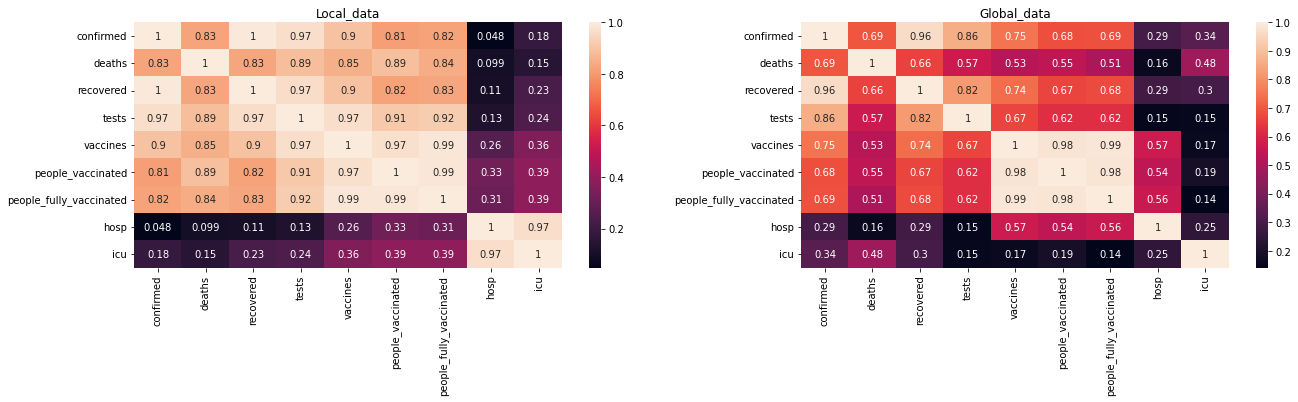

In [18]:
fig, ax =plt.subplots(1,2)
fig.tight_layout()
fig.set_figwidth(19)
sns.heatmap(local_x.corr().abs(),ax=ax[0],annot=True).set(title='Local_data')
sns.heatmap(global_x.corr().abs(),ax=ax[1],annot=True).set(title='Global_data') 

Lokalne: silna korelacja( możliwa współliniowość):
1.   confirmed i recovered
2.   vaccines i people_fully_vaccinated
3. people_fully_vaccinated i people_vaccinated

                        
Globalnie: silna korelacja: 
1.  vaccines i people_fully_vaccinated


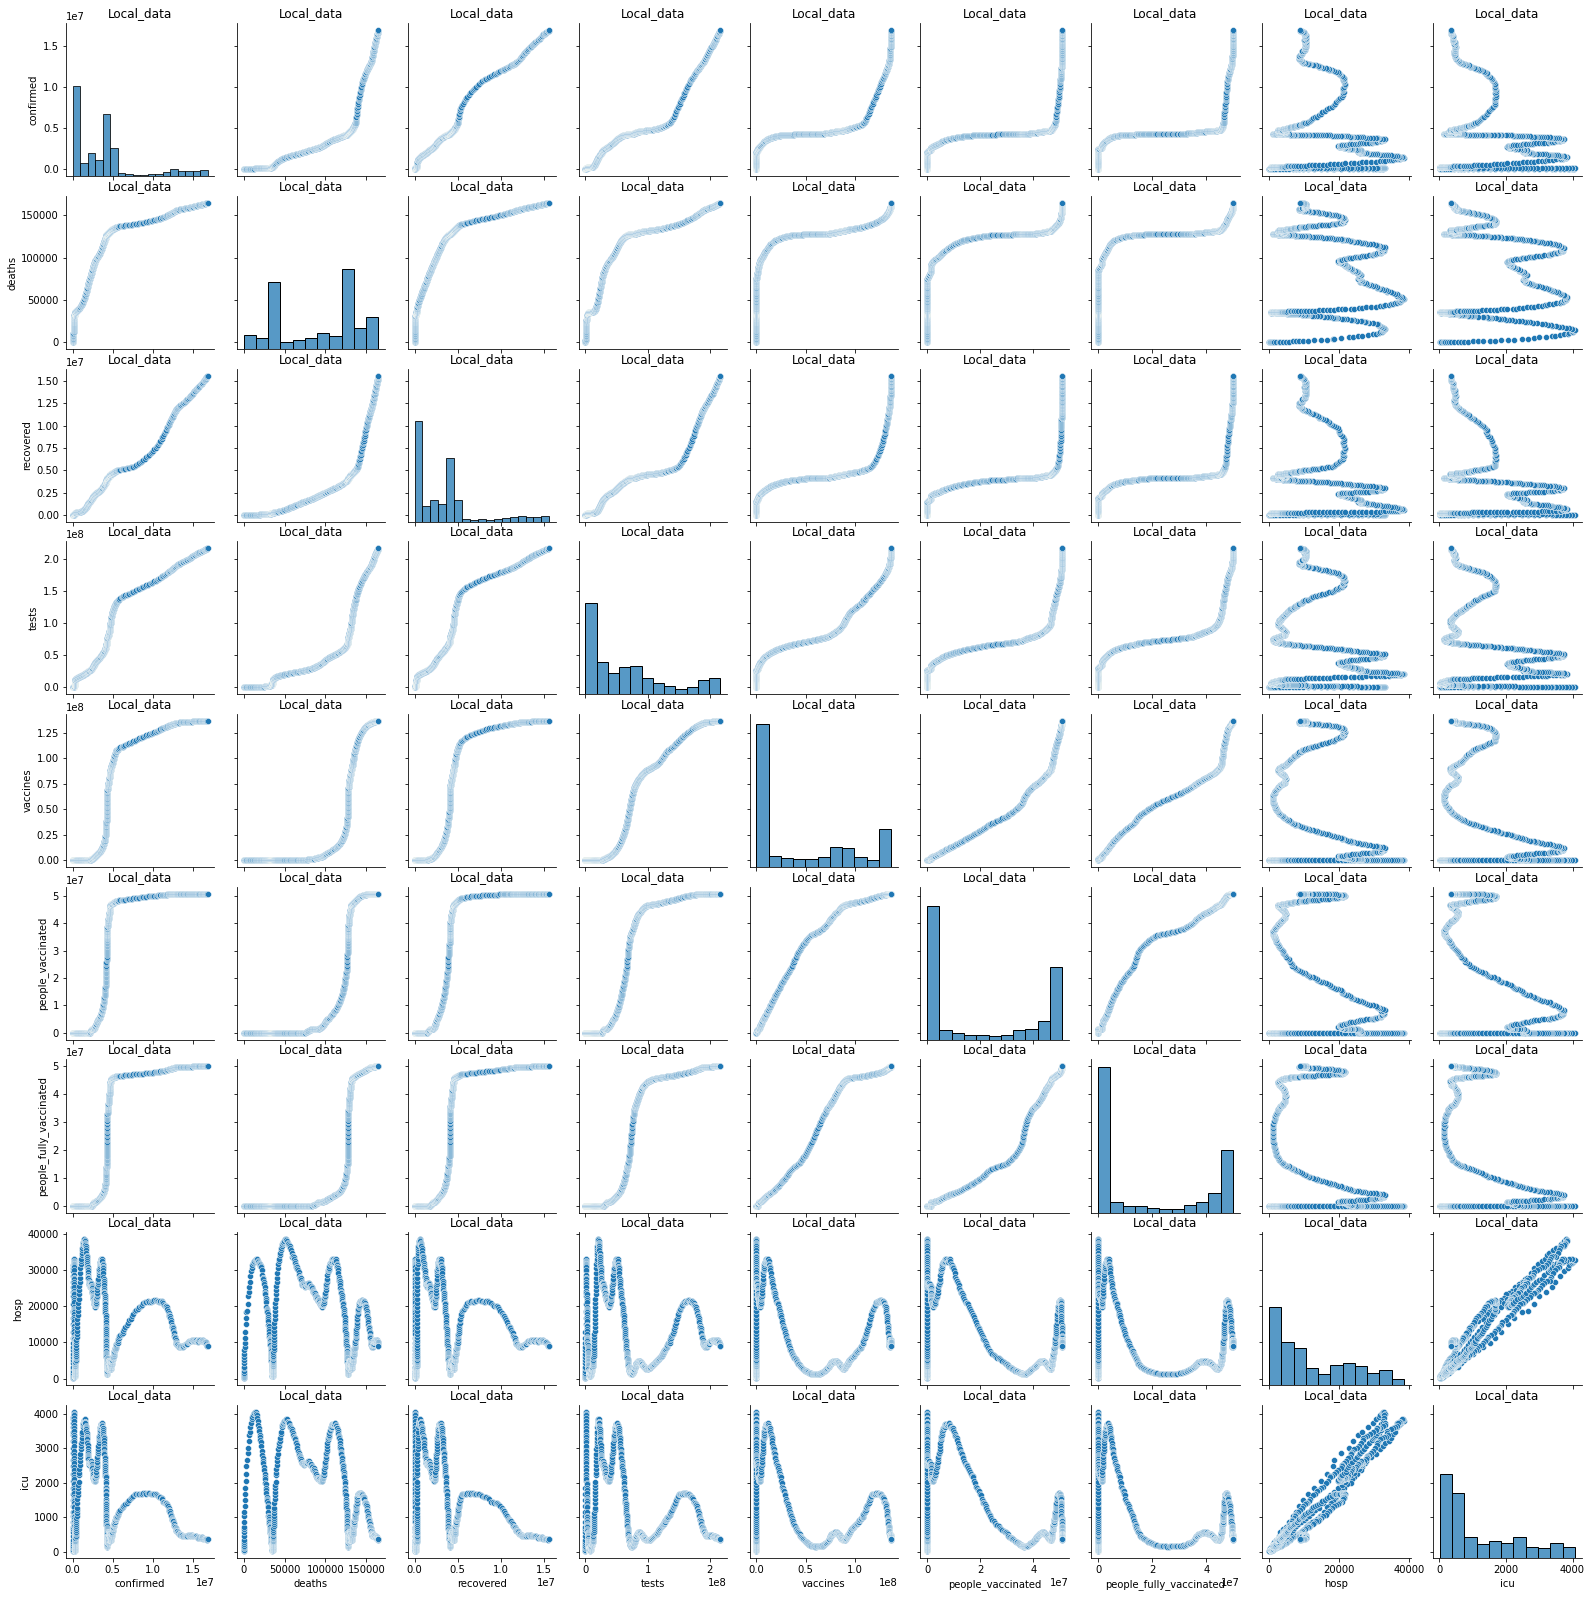

In [19]:
sns.pairplot(local_x).set(title='Local_data')

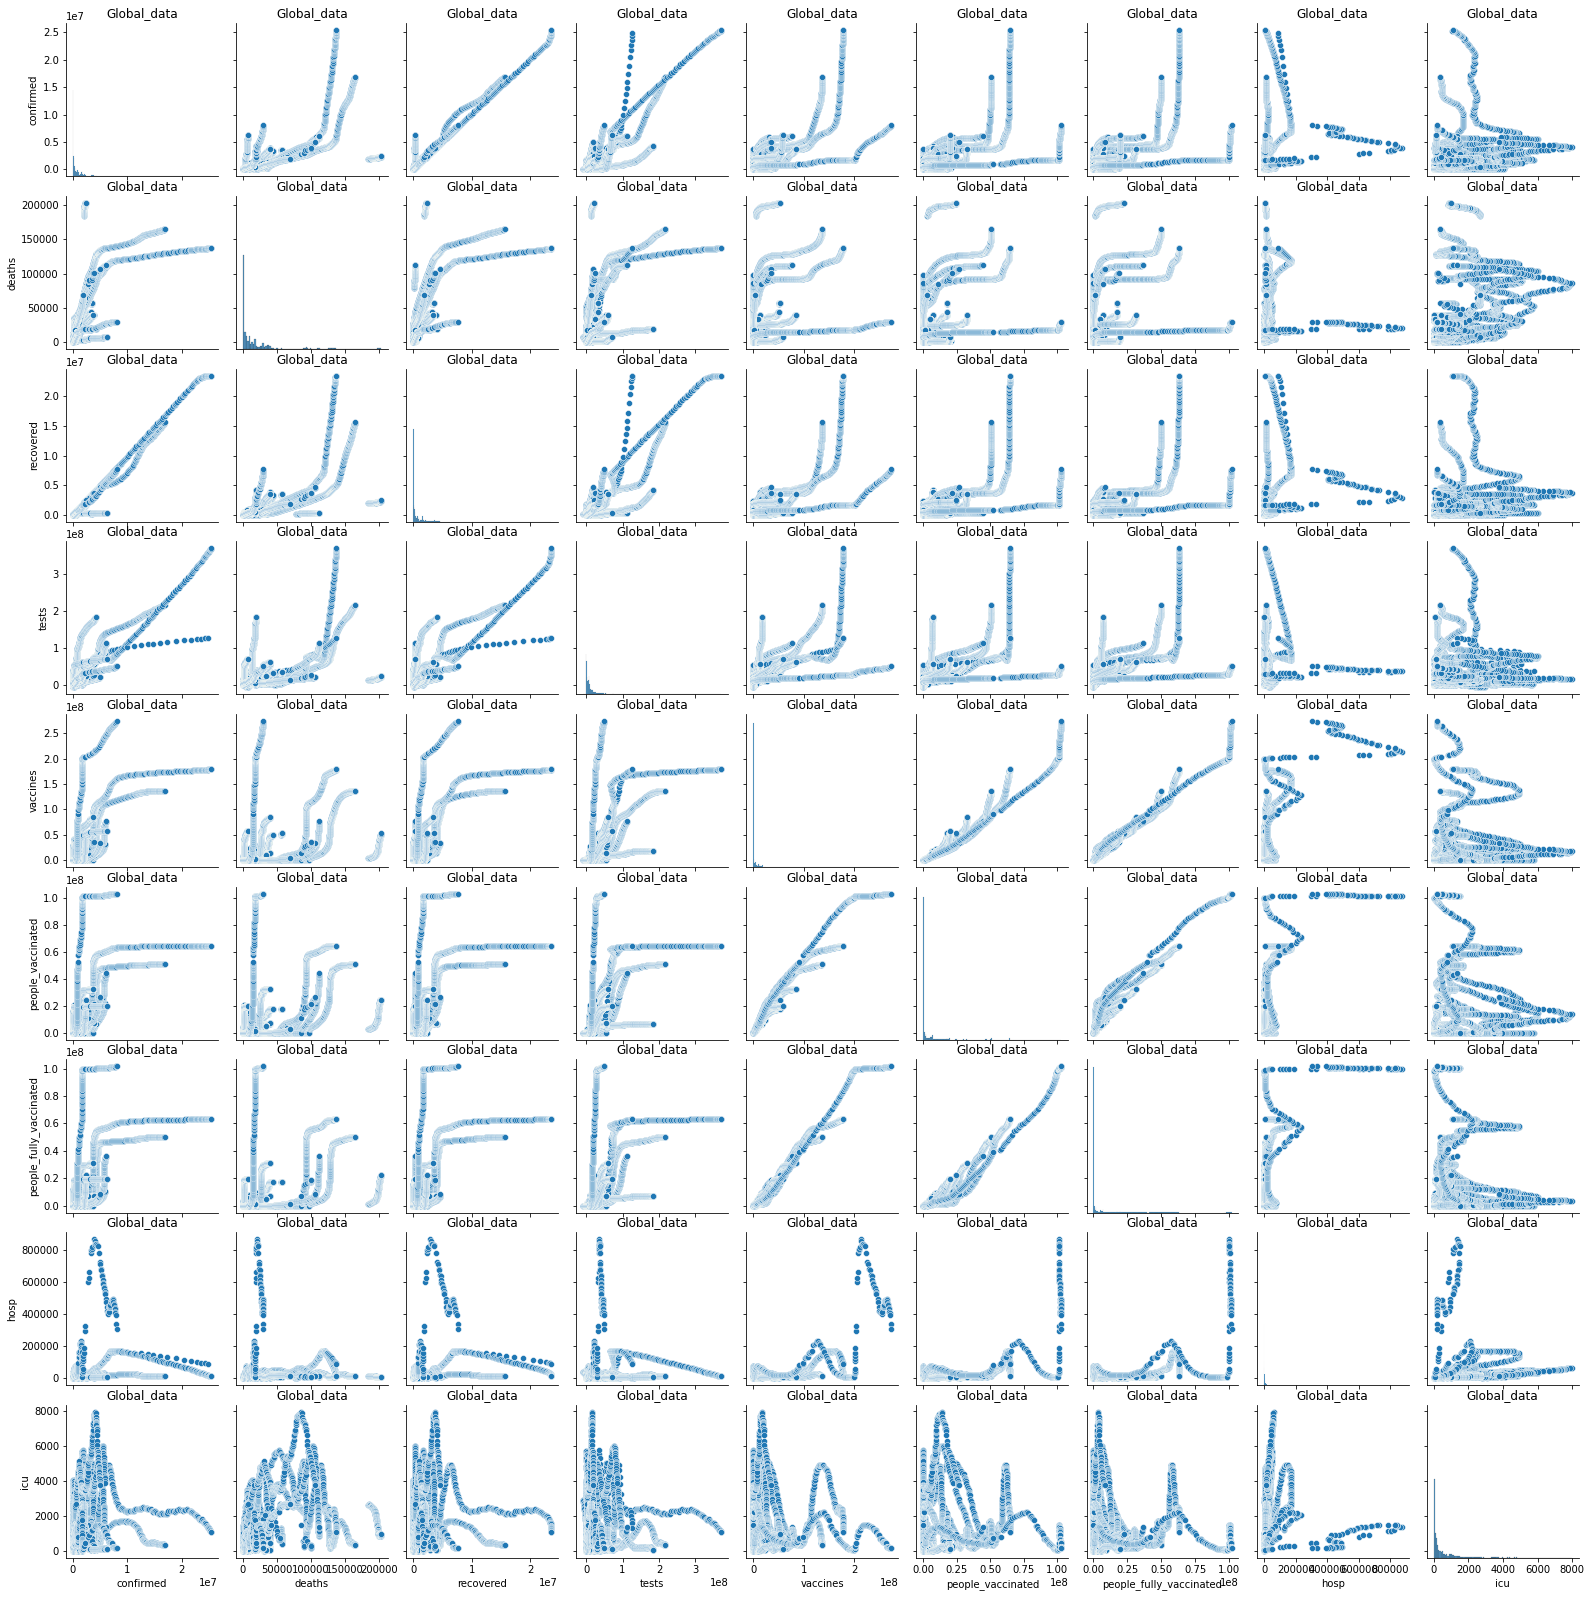

In [20]:
sns.pairplot(global_x).set(title='Global_data')

# Regresja liniowa

In [23]:
from sklearn.model_selection import train_test_split
X_train_glob_conf, X_test_glob_conf, y_train_glob_conf, y_test_glob_conf = train_test_split(global_x, global_x["confirmed"], test_size=0.3, random_state=0)
X_train_loc_conf, X_test_loc_conf, y_train_loc_conf, y_test_loc_conf = train_test_split(local_x, local_x["confirmed"], test_size=0.3, random_state=0)
X_train_glob_deaths, X_test_glob_deaths, y_train_glob_deaths, y_test_glob_deaths = train_test_split(global_x, global_x["deaths"], test_size=0.3, random_state=0)
X_train_loc_deaths, X_test_loc_deaths, y_train_loc_deaths, y_test_loc_deaths = train_test_split(local_x, local_x["deaths"], test_size=0.3, random_state=0)


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#local 

#deaths
features1=global_x.columns.drop("deaths")
local_deaths_score = list()
local_deaths_mse = list()
for feature in features1:
    reg = LinearRegression().fit(pd.DataFrame(X_train_loc_deaths[feature]),y_train_loc_deaths)
    PredTest = reg.predict(pd.DataFrame(X_test_loc_deaths[feature]))
    score = reg.score(pd.DataFrame(X_test_loc_deaths[feature]), y_test_loc_deaths)
    mse = mean_squared_error(y_test_loc_deaths,PredTest)
    local_deaths_score.append(score)
    local_deaths_mse.append(mse)
    
#confirmed
features2=global_x.columns.drop("confirmed")
local_conf_score = list()
local_conf_mse = list()
for feature in features2:
    reg = LinearRegression().fit(pd.DataFrame(X_train_loc_conf[feature]),y_train_loc_conf)
    PredTest = reg.predict(pd.DataFrame(X_test_loc_conf[feature]))
    score = reg.score(pd.DataFrame(X_test_loc_conf[feature]), y_test_loc_conf)
    mse = mean_squared_error(y_test_loc_conf,PredTest)
    local_conf_score.append(score)
    local_conf_mse.append(mse)

#global

#deaths
global_deaths_score = list()
global_deaths_mse = list()
for feature in features1:
    reg = LinearRegression().fit(pd.DataFrame(X_train_glob_deaths[feature]),y_train_glob_deaths)
    PredTest = reg.predict(pd.DataFrame(X_test_glob_deaths[feature]))
    score = reg.score(pd.DataFrame(X_test_glob_deaths[feature]), y_test_glob_deaths)
    mse = mean_squared_error(y_test_glob_deaths,PredTest)
    global_deaths_score.append(score)
    global_deaths_mse.append(mse)

#confirmed
global_conf_score = list()
global_conf_mse = list()
for feature in features2:
    reg = LinearRegression().fit(pd.DataFrame(X_train_glob_conf[feature]),y_train_glob_conf)
    PredTest = reg.predict(pd.DataFrame(X_test_glob_conf[feature]))
    score = reg.score(pd.DataFrame(X_test_glob_conf[feature]), y_test_glob_conf)
    mse = mean_squared_error(y_test_glob_conf,PredTest)
    global_conf_score.append(score)
    global_conf_mse.append(mse)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

[Text(0.5, 1.0, 'Global_conf_score')]

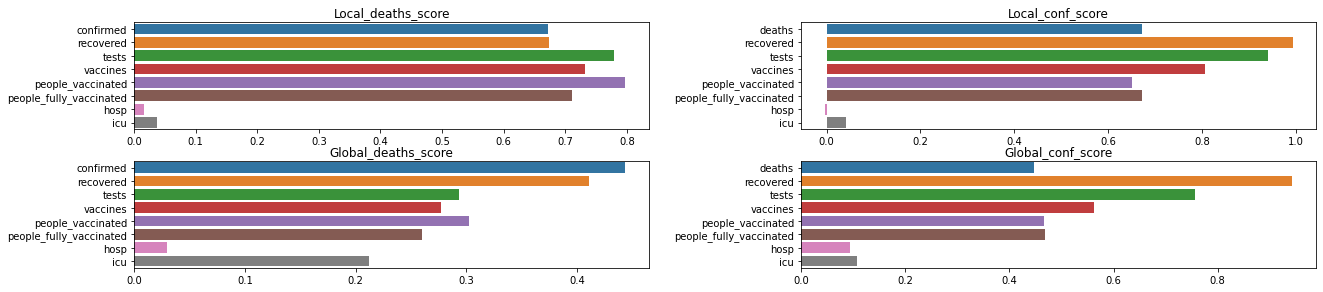

In [23]:
fig, ax =plt.subplots(2,2)
fig.tight_layout()
fig.set_figwidth(19)
sns.barplot(local_deaths_score,features1,ax=ax[0,0]).set(title='Local_deaths_score')
sns.barplot(local_conf_score,features2,ax=ax[0,1]).set(title='Local_conf_score')
sns.barplot(global_deaths_score,features1,ax=ax[1,0]).set(title='Global_deaths_score')
sns.barplot(global_conf_score,features2,ax=ax[1,1]).set(title='Global_conf_score')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

[Text(0.5, 1.0, 'Local_conf_mse')]

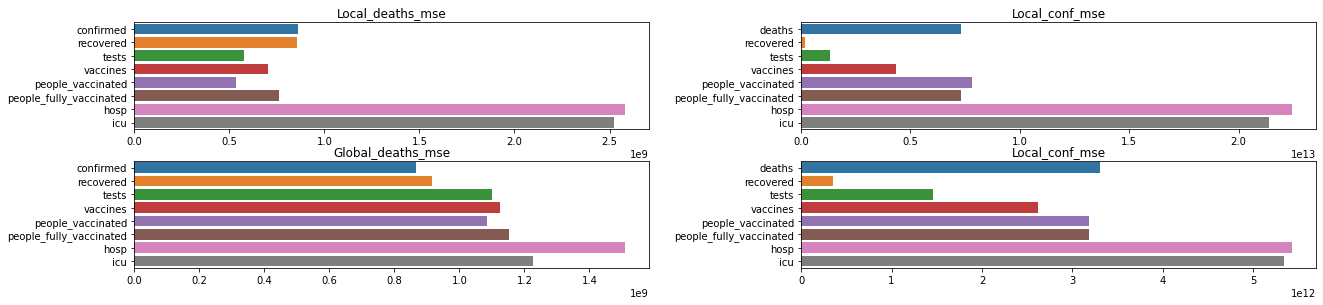

In [24]:
fig, ax =plt.subplots(2,2)
fig.tight_layout()
fig.set_figwidth(19)
sns.barplot(local_deaths_mse,features1,ax=ax[0,0]).set(title='Local_deaths_mse')
sns.barplot(local_conf_mse,features2,ax=ax[0,1]).set(title='Local_conf_mse')
sns.barplot(global_deaths_mse,features1,ax=ax[1,0]).set(title='Global_deaths_mse')
sns.barplot(global_conf_mse,features2,ax=ax[1,1]).set(title='Local_conf_mse')

In [25]:
print("Local_deaths ( people_vaccinated )")
print("Score :",local_deaths_score[4])
print("MSE :",local_deaths_mse[4])
print("Local_confirmed ( recovered )")
print("Score :",local_conf_score[1])
print("MSE :",local_conf_mse[1])
print("Global_deaths ( confirmed )")
print("Score :",global_deaths_score[0])
print("MSE :",global_deaths_mse[0])
print("Local_confirmed ( recovered )")
print("Score :",global_conf_score[1])
print("MSE :",global_conf_mse[1])

Local_deaths ( people_vaccinated )
Score : 0.7964998101520155
MSE : 533684754.7074789
Local_confirmed ( recovered )
Score : 0.9928362655560471
MSE : 159871356511.2085
Global_deaths ( confirmed )
Score : 0.4428015164469874
MSE : 866244389.4986433
Local_confirmed ( recovered )
Score : 0.9416754189752085
MSE : 348732984555.064


W przypadku danych lokalnych R^2 oraz MSE najlepsze wyniki uzyskała zmienna **people_vaccinated** dla predykcji **deaths** oraz **recovered** dla predykcji
**confirmed**

W przypadku danych globalnych R^2 oraz MSE najlepsze wyniki uzyskała zmienna **confirmed** dla predykcji **deaths** oraz **recovered** dla predykcji
**confirmed**



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Global_deaths')]

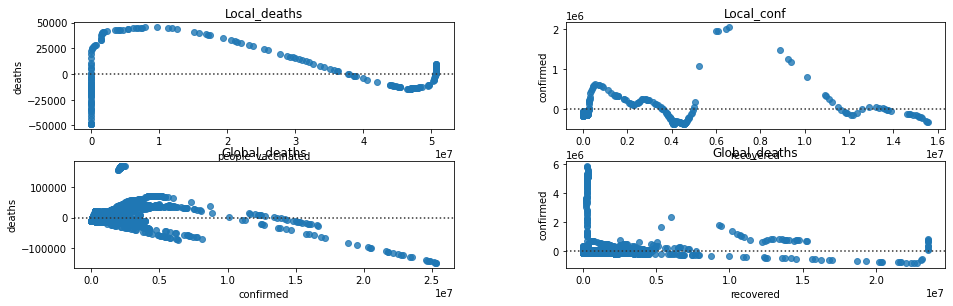

In [26]:
fig, ax =plt.subplots(2,2)
fig.tight_layout()
fig.set_figwidth(14)
sns.residplot(X_test_loc_deaths["people_vaccinated"],y_test_loc_deaths,ax=ax[0,0]).set(title='Local_deaths')
sns.residplot(X_test_loc_conf["recovered"],y_test_loc_conf,ax=ax[0,1]).set(title='Local_conf')
sns.residplot(X_test_glob_deaths["confirmed"],y_test_glob_deaths,ax=ax[1,0]).set(title='Global_deaths')
sns.residplot(X_test_glob_conf["recovered"],y_test_glob_conf,ax=ax[1,1]).set(title='Global_deaths')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

[Text(0.5, 1.0, 'Residuals_glob_conf')]

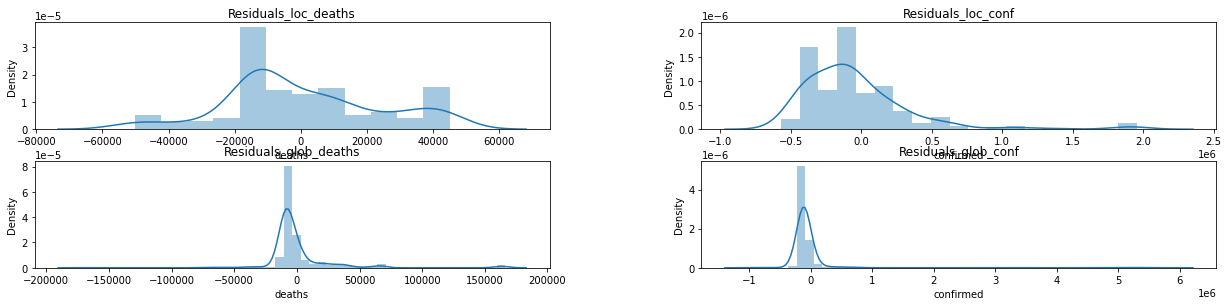

In [27]:
reg = LinearRegression().fit(pd.DataFrame(X_train_loc_deaths["people_vaccinated"]),y_train_loc_deaths)
PredTest_loc_deaths = reg.predict(pd.DataFrame(X_test_loc_deaths["people_vaccinated"]))
reg = LinearRegression().fit(pd.DataFrame(X_train_loc_conf["recovered"]),y_train_loc_conf)
PredTest_loc_conf = reg.predict(pd.DataFrame(X_test_loc_conf["recovered"]))
reg = LinearRegression().fit(pd.DataFrame(X_train_glob_deaths["confirmed"]),y_train_glob_deaths)
PredTest_glob_deaths = reg.predict(pd.DataFrame(X_test_glob_deaths["confirmed"]))
reg = LinearRegression().fit(pd.DataFrame(X_train_glob_conf["recovered"]),y_train_glob_conf)
PredTest_glob_conf = reg.predict(pd.DataFrame(X_test_glob_conf["recovered"]))

residuals_loc_deaths = abs(y_test_loc_deaths) - abs(PredTest_loc_deaths)
residuals_loc_conf = abs(y_test_loc_conf) - abs(PredTest_loc_conf)
residuals_glob_deaths = abs(y_test_glob_deaths) - abs(PredTest_glob_deaths)
residuals_glob_conf = abs(y_test_glob_conf) - abs(PredTest_glob_conf)

fig, ax =plt.subplots(2,2)
fig.tight_layout()
fig.set_figwidth(19)
sns.distplot(residuals_loc_deaths,ax=ax[0,0]).set(title='Residuals_loc_deaths')
sns.distplot(residuals_loc_conf,ax=ax[0,1]).set(title='Residuals_loc_conf')
sns.distplot(residuals_glob_deaths,ax=ax[1,0]).set(title='Residuals_glob_deaths')
sns.distplot(residuals_glob_conf,ax=ax[1,1]).set(title='Residuals_glob_conf')




# Regresja wielowymiarowa


## Lokalne

Przykładowa regresja wieloraka dla wszystkich zmiennych

In [28]:
col_names_deaths = local_x.columns.drop("deaths")
col_names_conf = local_x.columns.drop("confirmed")

features1 = col_names_deaths
features2 = col_names_conf

reg1 = LinearRegression().fit(pd.DataFrame(X_train_loc_deaths[features1]), y_train_loc_deaths)
reg2 = LinearRegression().fit(pd.DataFrame(X_train_loc_conf[features2]), y_train_loc_conf)

PredTest1 = reg1.predict(X_test_loc_deaths[features1])
PredTest2 = reg2.predict(X_test_loc_conf[features2])

r2_deaths = reg1.score(X_test_loc_deaths[features1], y_test_loc_deaths)
r2_conf = reg2.score(X_test_loc_conf[features2], y_test_loc_conf)
mse_deaths = mean_squared_error(y_test_loc_deaths,PredTest1)
mse_conf = mean_squared_error(y_test_loc_conf,PredTest2)
print("Deaths: ", "Score: ",r2_deaths,"MSE: ",mse_deaths  )
print("Confirmed: ","Score:",r2_conf,"MSE: ",mse_conf  )

print("Deaths: ")
# summarize feature importance
importance = reg1.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print("-----")
print("Confirmed: ")
importance2 = reg2.coef_
for i,v in enumerate(importance2):
    print('Feature: %0d, Score: %.5f' % (i,v))

Deaths:  Score:  0.9724202924578885 MSE:  72328529.35179482
Confirmed:  Score: 0.9983992122166093 MSE:  35724399950.818825
Deaths: 
Feature: 0, Score: 0.00957
Feature: 1, Score: -0.00935
Feature: 2, Score: 0.00170
Feature: 3, Score: -0.00420
Feature: 4, Score: 0.00505
Feature: 5, Score: 0.00185
Feature: 6, Score: 0.99907
Feature: 7, Score: -10.05223
-----
Confirmed: 
Feature: 0, Score: 7.26372
Feature: 1, Score: 0.79649
Feature: 2, Score: 0.00391
Feature: 3, Score: 0.05699
Feature: 4, Score: -0.03568
Feature: 5, Score: -0.07784
Feature: 6, Score: 57.03229
Feature: 7, Score: -371.50597


W naszym modelu regresji wielorakiej dla przypadku lokalnego wyrzucimy zmienne **"confirmed, people_fully_vaccinated" **, ponieważ wykazują współliniowosc z innymi zmiennymi i mają od nich mniejszą korelacje ze zmienną objaśnianą

In [29]:
features1 = col_names_deaths.drop(["confirmed","people_fully_vaccinated"])
features2 = col_names_conf.drop("people_fully_vaccinated")

reg1 = LinearRegression().fit(pd.DataFrame(X_train_loc_deaths[features1]), y_train_loc_deaths)
reg2 = LinearRegression().fit(pd.DataFrame(X_train_loc_conf[features2]), y_train_loc_conf)

PredTest1 = reg1.predict(X_test_loc_deaths[features1])
PredTest2 = reg2.predict(X_test_loc_conf[features2])

r2_deaths = reg1.score(X_test_loc_deaths[features1], y_test_loc_deaths)
r2_conf = reg2.score(X_test_loc_conf[features2], y_test_loc_conf)
mse_deaths = mean_squared_error(y_test_loc_deaths,PredTest1)
mse_conf = mean_squared_error(y_test_loc_conf,PredTest2)
print("Deaths: ", "Score: ",r2_deaths,"MSE: ",mse_deaths  )
print("Confirmed: ","Score:",r2_conf,"MSE: ",mse_conf  )

print("Deaths: ")
# summarize feature importance
importance = reg1.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print("-----")
print("Confirmed: ")
importance2 = reg2.coef_
for i,v in enumerate(importance2):
    print('Feature: %0d, Score: %.5f' % (i,v))

Deaths:  Score:  0.9694610212963937 MSE:  80089298.05237965
Confirmed:  Score: 0.997713679687866 MSE:  51023266227.93073
Deaths: 
Feature: 0, Score: -0.00236
Feature: 1, Score: 0.00176
Feature: 2, Score: -0.00343
Feature: 3, Score: 0.00543
Feature: 4, Score: 1.64703
Feature: 5, Score: -14.19366
-----
Confirmed: 
Feature: 0, Score: 1.95298
Feature: 1, Score: 0.81738
Feature: 2, Score: 0.02010
Feature: 3, Score: 0.00657
Feature: 4, Score: -0.03093
Feature: 5, Score: 66.66054
Feature: 6, Score: -475.11247


## Globalne

Przykładowa regresja wieloraka dla wszystkich zmiennych

In [ ]:
col_names_deaths = global_x.columns.drop("deaths")
col_names_conf = global_x.columns.drop("confirmed")

features1 = col_names_deaths
features2 = col_names_conf

reg1 = LinearRegression().fit(pd.DataFrame(X_train_glob_deaths[features1]), y_train_glob_deaths)
reg2 = LinearRegression().fit(pd.DataFrame(X_train_glob_conf[features2]), y_train_glob_conf)

PredTest1 = reg1.predict(X_test_glob_deaths[features1])
PredTest2 = reg2.predict(X_test_glob_conf[features2])

r2_deaths = reg1.score(X_test_glob_deaths[features1], y_test_glob_deaths)
r2_conf = reg2.score(X_test_glob_conf[features2], y_test_glob_conf)
mse_deaths = mean_squared_error(y_test_glob_deaths,PredTest1)
mse_conf = mean_squared_error(y_test_glob_conf,PredTest2)
print("Deaths: ", "Score: ",r2_deaths,"MSE: ",mse_deaths  )
print("Confirmed: ","Score:",r2_conf,"MSE: ",mse_conf  )

print("Deaths: ")
# summarize feature importance
importance = reg1.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print("-----")
print("Confirmed: ")
importance2 = reg2.coef_
for i,v in enumerate(importance2):
    print('Feature: %0d, Score: %.5f' % (i,v))

W naszym modelu regresji wielorakiej dla przypadku globalnego wyrzucimy zmienną **"people_fully_vaccinated"**, ponieważ wykazuje współliniowosc ze zmienną **"confirmed"** i ma od niej mniejszą korelacje ze zmienną objaśnianą

In [ ]:
features1 = col_names_deaths.drop(["people_fully_vaccinated"])
features2 = col_names_conf.drop(["people_fully_vaccinated"])
reg1 = LinearRegression().fit(pd.DataFrame(X_train_glob_deaths[features1]), y_train_glob_deaths)
reg2 = LinearRegression().fit(pd.DataFrame(X_train_glob_conf[features2]), y_train_glob_conf)

PredTest1 = reg1.predict(X_test_glob_deaths[features1])
PredTest2 = reg2.predict(X_test_glob_conf[features2])

r2_deaths = reg1.score(X_test_glob_deaths[features1], y_test_glob_deaths)
r2_conf = reg2.score(X_test_glob_conf[features2], y_test_glob_conf)
mse_deaths = mean_squared_error(y_test_glob_deaths,PredTest1)
mse_conf = mean_squared_error(y_test_glob_conf,PredTest2)
print("Deaths: ", "Score: ",r2_deaths,"MSE: ",mse_deaths  )
print("Confirmed: ","Score:",r2_conf,"MSE: ",mse_conf  )

print("Deaths: ")
# summarize feature importance
importance = reg1.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print("-----")
print("Confirmed: ")
importance2 = reg2.coef_
for i,v in enumerate(importance2):
    print('Feature: %0d, Score: %.5f' % (i,v))

# Porównanie modeli liniowych i wielowymiarowych

**Model liniowy**
> Dobre rezultaty otrzymaliśmy dla predykcji zmiennej **"confirmed"**.
*   Lokalnie - score 0.993
*   Globalnie - score 0.941

> W przypadku predykcji zmiennej **"deaths"** wyniki okazały sie gorsze.
*   Lokalnie - score 0.797
*   Globalnie - score 0.443

**Model wieloraki**

> W przypadku danych **lokalnych** wyniki dla obu predykcji byly bardzo dobre:
*   Deaths - score 0.969
*   Confirmed - score 0.998

> W przypadku danych **globalnych** wyniki okazały sie zadowalajace jedynie dla predykcji "**confirmed"**
*   Deaths - score 0.61
*   Confirmed - score 0.962

**Porównując oba modele lepsze rezultaty w przypadku każdej predykcji osiągnął model wieloraki.**








# Algorytmy SVR

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline

# features1 = col_names_deaths.drop(["confirmed","people_fully_vaccinated"])
# features2 = col_names_conf.drop("people_fully_vaccinated")

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train_loc_deaths[features1], y_train_loc_deaths)
# PredTest_loc_deaths = clf.predict(X_test_loc_deaths[features1].fillna(0))
# score = clf.score(pd.DataFrame(X_test_loc_deaths[features1]), y_test_loc_deaths)
# mse = mean_squared_error(y_test_loc_deaths,PredTest_loc_deaths)

# print(score,mse)


# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train_loc_conf[features2], y_train_loc_conf)
# PredTest_loc_conf = clf.predict(X_test_loc_conf[features2].fillna(0))
# score = clf.score(pd.DataFrame(X_test_loc_conf[features2]), y_test_loc_conf)
# mse = mean_squared_error(y_test_loc_conf,PredTest_loc_conf)

# print(score,mse)

# features1 = col_names_deaths.drop(["people_fully_vaccinated"])
# features2 = col_names_conf.drop(["people_fully_vaccinated"])

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train_glob_deaths[features1], y_train_glob_deaths)
# PredTest_glob_deaths = clf.predict(X_test_glob_deaths[features1].fillna(0))
# score = clf.score(pd.DataFrame(X_test_glob_deaths[features1]), y_test_glob_deaths)
# mse = mean_squared_error(y_test_glob_deaths,PredTest_glob_deaths)

# print(score,mse)

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train_glob_conf[features2], y_train_glob_conf)
# PredTest_glob_conf = clf.predict(X_test_glob_conf[features2].fillna(0))
# score = clf.score(pd.DataFrame(X_test_glob_conf[features2]), y_test_glob_conf)
# mse = mean_squared_error(y_test_glob_conf,PredTest_glob_conf)

# print(score,mse)


0.0 151701.19341563786
0.0 1878427442.8930042


# Drzewa regresyjne

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)

features1 = col_names_deaths.drop(["confirmed","people_fully_vaccinated"])
features2 = col_names_conf.drop("people_fully_vaccinated")

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train_loc_deaths[features1], y_train_loc_deaths)
PredTest_loc_deaths = regressor.predict(X_test_loc_deaths[features1].fillna(0))
score = regressor.score(pd.DataFrame(X_test_loc_deaths[features1]), y_test_loc_deaths)
mse = mean_squared_error(y_test_loc_deaths,PredTest_loc_deaths)

print(score,mse)

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train_loc_conf[features2], y_train_loc_conf)
PredTest_loc_conf = regressor.predict(X_test_loc_conf[features2].fillna(0))
score = regressor.score(pd.DataFrame(X_test_loc_conf[features2]), y_test_loc_conf)
mse = mean_squared_error(y_test_loc_conf,PredTest_loc_conf)

print(score,mse)

features1 = col_names_deaths.drop(["people_fully_vaccinated"])
features2 = col_names_conf.drop(["people_fully_vaccinated"])

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train_glob_deaths[features1], y_train_glob_deaths)
PredTest_glob_deaths = regressor.predict(X_test_glob_deaths[features1].fillna(0))
score = regressor.score(pd.DataFrame(X_test_glob_deaths[features1]), y_test_glob_deaths)
mse = mean_squared_error(y_test_glob_deaths,PredTest_glob_deaths)

print(score,mse)

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train_glob_conf[features2], y_train_glob_conf)
PredTest_glob_conf = regressor.predict(X_test_glob_conf[features2].fillna(0))
score = regressor.score(pd.DataFrame(X_test_glob_conf[features2]), y_test_glob_conf)
mse = mean_squared_error(y_test_glob_conf,PredTest_glob_conf)

print(score,mse)


0.9999530203673102 123205.35802469136
0.9999009290567815 2210942659.4609056
0.9958079394778514 6517155.044275173
0.9998010305448273 1189673559.9040346


# Losowy las regresyjny

In [1]:
# from sklearn.ensemble import RandomForestClassifier

# regressor = DecisionTreeRegressor(random_state=0)

# features1 = col_names_deaths.drop(["confirmed","people_fully_vaccinated"])
# features2 = col_names_conf.drop("people_fully_vaccinated")

# forest = RandomForestClassifier(random_state=0)
# forest.fit(X_train_loc_deaths[features1], y_train_loc_deaths)
# PredTest_loc_deaths = forest.predict(X_test_loc_deaths[features1].fillna(0))
# score = forest.score(pd.DataFrame(X_test_loc_deaths[features1]), y_test_loc_deaths)
# mse = mean_squared_error(y_test_loc_deaths,PredTest_loc_deaths)

# print(score,mse)

# forest = RandomForestClassifier(random_state=0)
# forest.fit(X_train_loc_conf[features2], y_train_loc_conf)
# PredTest_loc_conf = forest.predict(X_test_loc_conf[features2].fillna(0))
# score = forest.score(pd.DataFrame(X_test_loc_conf[features2]), y_test_loc_conf)
# mse = mean_squared_error(y_test_loc_conf,PredTest_loc_conf)

# print(score,mse)

# features1 = col_names_deaths.drop(["people_fully_vaccinated"])
# features2 = col_names_conf.drop(["people_fully_vaccinated"])

# forest = RandomForestClassifier(random_state=0)
# forest.fit(X_train_glob_deaths[features1], y_train_glob_deaths)
# PredTest_glob_deaths = forest.predict(X_test_glob_deaths[features1].fillna(0))
# score = forest.score(pd.DataFrame(X_test_glob_deaths[features1]), y_test_glob_deaths)
# mse = mean_squared_error(y_test_glob_deaths,PredTest_glob_deaths)

# print(score,mse)

# forest = RandomForestClassifier(random_state=0)
# forest.fit(X_train_glob_conf[features2], y_train_glob_conf)
# PredTest_glob_conf = forest.predict(X_test_glob_conf[features2].fillna(0))
# score = forest.score(pd.DataFrame(X_test_glob_conf[features2]), y_test_glob_conf)
# mse = mean_squared_error(y_test_glob_conf,PredTest_glob_conf)

# print(score,mse)

NameError: ignored

# Porównanie działania algorytmów


**Algorytmy SVR** oraz **Losowy las regresyjny** w przypadku danych lokalnych dają nieprawidłowe wyniki ( score 0.0 ), lub nie działają w ogóle w przypadku danych globalnych.

Drzewa regresyjne osiągnęły wysokie rezultaty ( score ok. 0.99 ) dla każdej predykcji, jednakże można mieć zastrzeżenia do ich wiarygodności (overfitting).

# Podsumowanie


Podsumowując naszą analizę, uważam, że dane COVID19 są trudnym zbiorem wymagającym dużo pracy na etapia przygotowania. Liczne braki danych utrudniają podejście do rozwiązania problemu.

Algorytmy predykcyjne oparte na regresji są dobrym rozwiązaniem w przypadku danych lokalnych, ponieważ dają zadowalające rezultaty, a dane mają odpowiednią strukturę.

W przypadku danych globalnych występuje duże zróżnicowanie oraz braki wartości. W celu polepszenia ich analizy należy rozpatrywać każdy kraj/region osobno, a następnie na podstawie tego dokonywać globalnej predykcji.

Problemu tego nie można rozparywać globalnie, ponieważ jest on silnie uzależniony on danego regionu, a dane nie są standaryzowane pod kątem globalnym.

Pozostałe algorytmy użyte w analizie nie sprawdzają się dla naszego przypadku.

Po przeprowadzeniu analizy, doszedłem do wniosków, że liczba zgonów jest trudna do przewidzenia, natomiast liczba potwierdzonych przypadków jest daną niewiele wartą, ponieważ silnie zależy od liczby testów, która nie jest stała w czasie.
Z tego też powodu zadowalające wyniki dla predykcji potwierdzonych przypadków globalnie, które są jedynie zasługą korelacji z liczbą testów, nie mogą stanowić samoistnie opini na temat rozpatrywania tego problemu globalnie.

